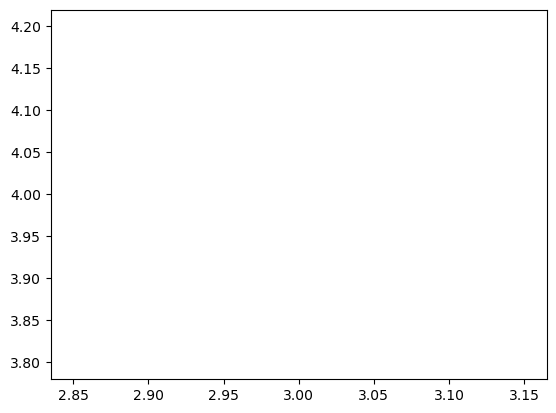

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(3, 4)

In [2]:
import torch
import os
import numpy as np
import json
import seaborn as sns
import gymnasium as gym
from reward_model import simple_NN, train_reward_model
from config import NUM_OBSERVATIONS, RELU_ALPHA
from reinforce import Policy_Network, REINFORCE, get_goal, record_video_policy_goal
from mujoco_to_GPT import extract_features
from PPO import get_reward_tensor

In [3]:
# Create and wrap the environment
env = gym.make("Reacher-v4")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes =  int(2e3)  # Total number of episodes
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]
agent = REINFORCE(obs_space_dims, action_space_dims)

Import error. Trying to rebuild mujoco_py.


In [4]:
my_reward_model = simple_NN(NUM_OBSERVATIONS, 8, RELU_ALPHA)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(my_reward_model.parameters(), lr=0.001)
rewards_over_rounds = []
rewards_over_rounds_true = []

In [5]:
goal_init = [0.08745539, 0.17655098]

In [121]:
experiment_name = 's_step5'
save_path = 'results/' + experiment_name + '_rewardModel.pth'
torch.save(my_reward_model.state_dict(), save_path)

### Record Video

In [124]:
video_directory = 'videos/April'
file_path = os.path.join(video_directory,f"{experiment_name}")

In [125]:
env = gym.make("Reacher-v4", render_mode="rgb_array")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

In [126]:
num_videos = 1
outputs_to_save = record_video_policy_goal(wrapped_env, 
                                      agent, 
                                      video_directory, 
                                      experiment_name,  
                                      goal_init, 
                                      num_episodes=num_videos)

episode  1 out of  1
Moviepy - Building video videos/April\march26_009_018_step5_episode_1.mp4.
Moviepy - Writing video videos/April\march26_009_018_step5_episode_1.mp4



Moviepy - Done !
Moviepy - video ready videos/April\march26_009_018_step5_episode_1.mp4
Moviepy - Building video videos/April\march26_009_018_step5_episode_1.mp4.
Moviepy - Writing video videos/April\march26_009_018_step5_episode_1.mp4



Moviepy - Done !
Moviepy - video ready videos/April\march26_009_018_step5_episode_1.mp4
saved


In [127]:
info = torch.load(os.path.join(video_directory,f"{experiment_name}_data.pth"))
info_GPT = []
for ii in range(len(info)):
    info_GPT.append(extract_features(info[ii][1:]))
torch.save(info_GPT, os.path.join(video_directory,f"{experiment_name}_data_infoGPT.pth"))

### Translate Feedback to Training Data
1. Get feedback (ask human)
2. Call ChatGPT (HF_to_rewards)

In [113]:
train_names.append(experiment_name)

In [114]:
train_names

['march26_009_018_step0',
 'march26_009_018_step1',
 'march26_009_018_step2',
 'march26_009_018_step3',
 'march26_009_018_step4']

### Train Reward Model

In [115]:
x_train, y_train = get_reward_tensor(video_directory, train_names)

Epoch [50/100], Training Loss: 0.6038, Test Loss: 0.4052
Epoch [100/100], Training Loss: 0.5628, Test Loss: 0.3841


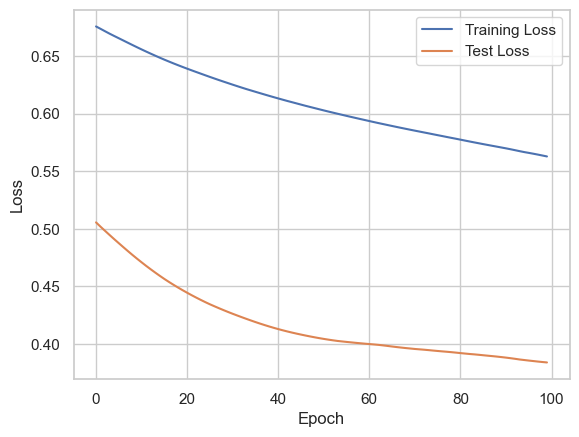

In [116]:
num_epochs = 100
optimizer = torch.optim.Adam(my_reward_model.parameters(), lr=0.001)
train_reward_model(my_reward_model, x_train, y_train.squeeze(), x_test, y_test, optimizer, criterion, num_epochs)

### Run Reinforce

In [122]:
# Create and wrap the environment
env = gym.make("Reacher-v4")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes =  int(2e3)  # Total number of episodes
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]

reward_over_episodes = []
reward_over_episodes_true = []

for episode in range(total_num_episodes):
    wrapped_env.reset()
    # Reset Position and velocity but mantain target
    qpos = (
        np.random.uniform(low=-0.1, high=0.1, size=wrapped_env.model.nq) + wrapped_env.init_qpos
    )
    wrapped_env.goal = goal_init
    qpos[-2:] = goal_init
    qvel = wrapped_env.init_qvel + np.random.uniform(
        low=-0.005, high=0.005, size=wrapped_env.model.nv
    )
    qvel[-2:] = 0
    wrapped_env.set_state(qpos, qvel)

    theta = wrapped_env.data.qpos.flat[:2]
    obs = np.concatenate(
        [
            np.cos(theta),
            np.sin(theta),
            wrapped_env.data.qpos.flat[2:],
            wrapped_env.data.qvel.flat[:2],
            wrapped_env.get_body_com("fingertip") - wrapped_env.get_body_com("target"),
        ]
    )

    done = False
    while not done:
        action = agent.sample_action(obs)
        obs, reward_true, terminated, truncated, info = wrapped_env.step(action)
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        predicted_reward = my_reward_model(obs_tensor).detach().numpy()

        agent.rewards.append(predicted_reward)
        done = terminated or truncated

    reward_over_episodes.append(predicted_reward)
    reward_over_episodes_true.append(wrapped_env.return_queue[-1])
    agent.update()

    if episode % 1000 == 0:
        avg_reward = int(np.mean(wrapped_env.return_queue))
        print("Episode:", episode, "Average Reward:", avg_reward)

rewards_over_rounds = rewards_over_rounds + reward_over_episodes
rewards_over_rounds_true = rewards_over_rounds_true + reward_over_episodes_true

Episode: 0 Average Reward: -36
Episode: 1000 Average Reward: -53


## Plot learning curve




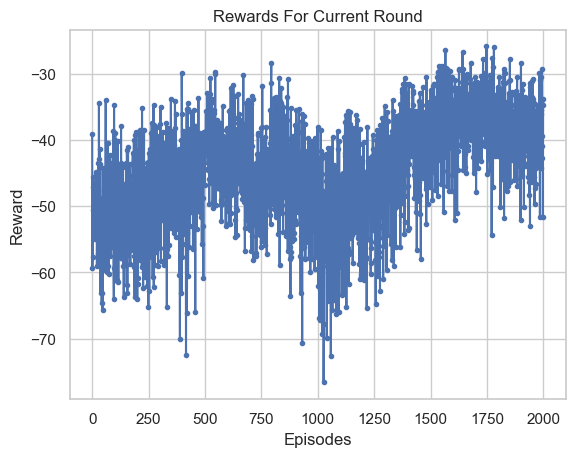

In [118]:
# Extracting the rewards from the nested lists
rewards = [float(reward[0]) for reward in reward_over_episodes_true]

# Plotting the rewards over episodes
plt.plot(rewards, marker='.', linestyle='-')
plt.title('Rewards For Current Round')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

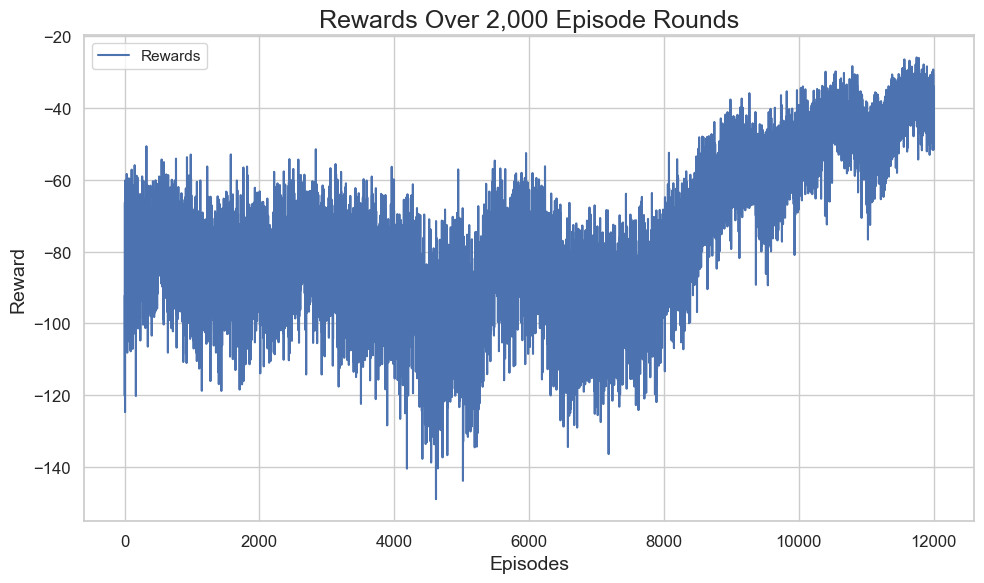

In [119]:
sns.set(style="whitegrid")
rewards = [float(reward[0]) for reward in rewards_over_rounds_true]
# Plotting the rewards over episodes
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(rewards) + 1), y=rewards, color='b', label='Rewards')
plt.title('Rewards Over 2,000 Episode Rounds', fontsize=18)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


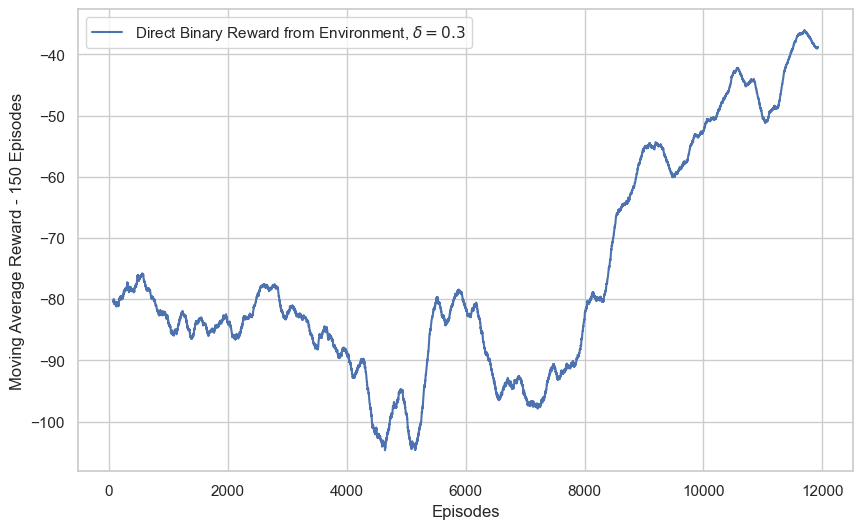

In [120]:
window_size = 150
rewards_env = np.array(rewards_over_rounds_true).squeeze()
N_episodes = len(rewards_env)
smoothed_episodes = np.arange(window_size // 2 + 1, (N_episodes + 1) - window_size // 2)



smoothed_rewards_env = np.convolve(rewards_env, np.ones(window_size)/window_size, mode='valid')

# Plot the smoothed mean rewards
plt.figure(figsize=(10, 6))
plt.plot(smoothed_episodes, smoothed_rewards_env[:-1], label='Direct Binary Reward from Environment, $\delta = 0.3$')
plt.xlabel('Episodes')
plt.ylabel('Moving Average Reward - 150 Episodes')
plt.legend()
plt.grid(True)
plt.show()


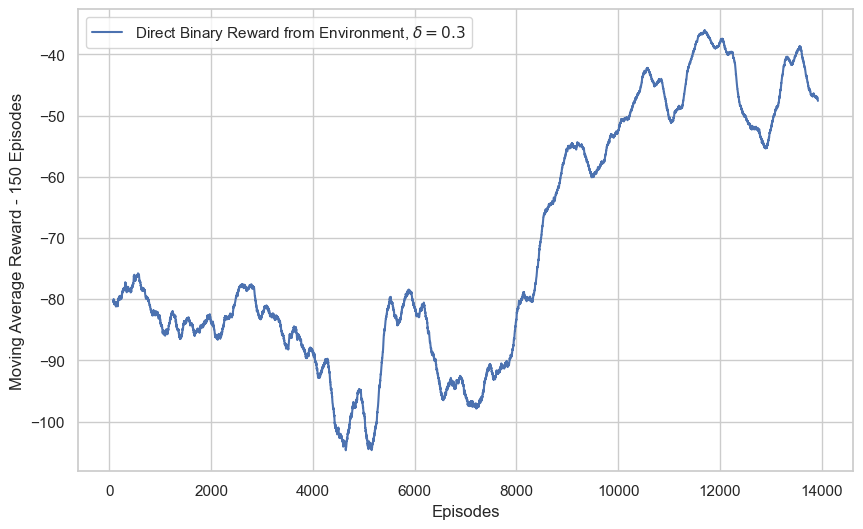

In [123]:
window_size = 150
rewards_env = np.array(rewards_over_rounds_true).squeeze()
N_episodes = len(rewards_env)
smoothed_episodes = np.arange(window_size // 2 + 1, (N_episodes + 1) - window_size // 2)



smoothed_rewards_env = np.convolve(rewards_env, np.ones(window_size)/window_size, mode='valid')

# Plot the smoothed mean rewards
plt.figure(figsize=(10, 6))
plt.plot(smoothed_episodes, smoothed_rewards_env[:-1], label='Direct Binary Reward from Environment, $\delta = 0.3$')
plt.xlabel('Episodes')
plt.ylabel('Moving Average Reward - 150 Episodes')
plt.legend()
plt.grid(True)
plt.show()
